#### 딥러닝을 이용한 추천시스템


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 200)               188800    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 200)               336600    ['input_2[0][0]']             
                                                                                              

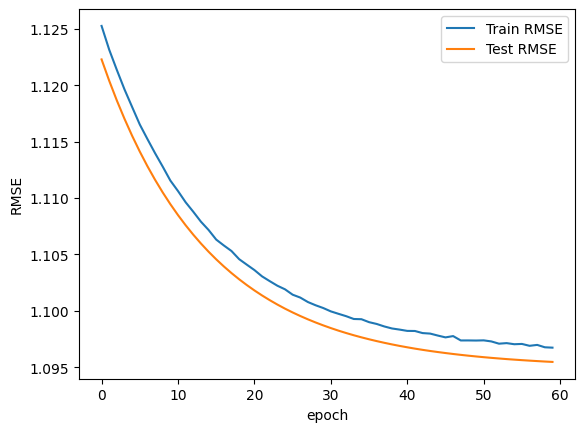

1/1 [==============================] - 0s 134ms/step
Actuals: 
        user_id  movie_id  rating
68617      790       209       1
85001      497       739       4
40035      648       411       2
6499       286       683       5
35686      132       151       3
16147      257      1008       5

Predictions: 
 [[3.5199063]
 [3.4827738]
 [3.454584 ]
 [3.527114 ]
 [3.548544 ]
 [3.541993 ]]
782/782 [==============================] - 2s 2ms/step


1.0963626070113301

In [ ]:
# MF를 신경망으로 변환

import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/movielens/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

##### (1)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# Variable 초기화
K = 200                             # Latent factor 수
mu = ratings_train.rating.mean()    # 전체 평균
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

##### (2)

# Keras model
user = Input(shape=(1, )) # User input
item = Input(shape=(1, )) # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user) # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item) # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user) # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item) # Item bias term (N, 1, )

#R = Dot(axes=2)([P_embedding, Q_embedding)
R = layers.dot([P_embedding, Q_embedding], axes=2) # (1, 1, 1)
#R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R) # (1, 1)

# Model setting
model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=60,
  batch_size=256,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 1, 200)               188800    ['input_3[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 200)               336600    ['input_4[0][0]']             
                                                                                            

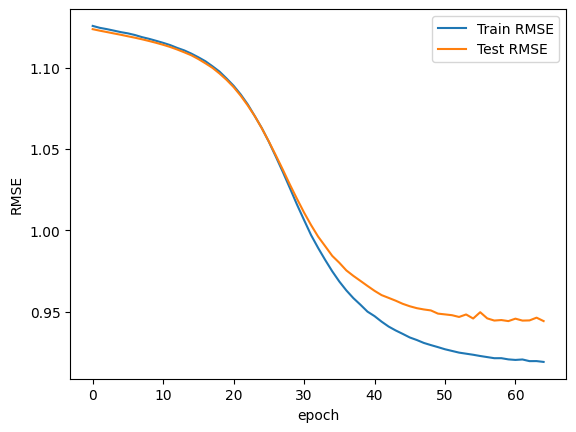

1/1 [==============================] - 0s 135ms/step
Actuals: 
        user_id  movie_id  rating
77914      621       783       3
15370       94      1226       4
97758      308       513       3
60577      456         4       3
70196      655       735       3
41399       13       636       2

Predictions: 
 [[2.9460359]
 [3.3739822]
 [4.3129234]
 [3.415521 ]
 [3.2512655]
 [2.9736707]]
782/782 [==============================] - 4s 5ms/step


0.9447513728013369

In [ ]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/movielens/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]



import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

# Variable 초기화
K = 200 # Latent factor 수
mu = ratings_train.rating.mean() # 전체 평균
M = ratings.user_id.max() + 1 # Number of users
N = ratings.movie_id.max() + 1 # Number of movies

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Keras model
user = Input(shape=(1, )) # User input
item = Input(shape=(1, )) # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user) # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item) # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user) # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item) # Item bias term (N, 1, )

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding) # (K, )
Q_embedding = Flatten()(Q_embedding) # (K, )
user_bias = Flatten()(user_bias) # (1, )
item_bias = Flatten()(item_bias) # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias]) # (2K + 2, )

# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

# 정확도(RMSE)를 계산
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 1, 200)               188800    ['input_5[0][0]']             
                                                                                            

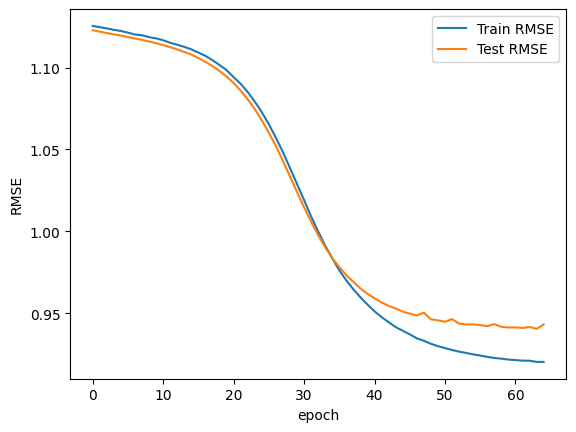

1/1 [==============================] - 0s 124ms/step
Actuals: 
        user_id  movie_id  rating
49433       37       405       4
62172      621       686       5
85263      833       840       2
86613      472       385       5
95336      892       470       4
24357       80       213       3

Predictions: 
 [[3.4157457]
 [3.6797183]
 [2.1553166]
 [4.491473 ]
 [3.9372723]
 [3.9000568]]
782/782 [==============================] - 5s 6ms/step


0.9435499769235965

In [ ]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/movielens/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]


u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/content/drive/MyDrive/movielens/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'occupation']]

# Convert occupation(string to integer)
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]
users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation)
train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

# Variable 초기화
K = 200 # Latent factor 수
mu = ratings_train.rating.mean() # 전체 평균
M = ratings.user_id.max() + 1 # Number of users
N = ratings.movie_id.max() + 1 # Number of movies

# RMSE
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

occ = Input(shape=(1, ))
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
occ_layer = Flatten()(occ_embedding)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])

# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)


model = Model(inputs=[user, item, occ], outputs=R)

model.compile(
  loss=RMSE,
  optimizer=SGD(),
  metrics=[RMSE]
)
model.summary()

# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],
    ratings_test.rating.values - mu
  )
)

# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
user_occ = test_occ[0:6]
predictions = model.predict([user_ids, movie_ids, user_occ]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

# RMSE
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids, test_occ]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

